# Using ViT for melspectrogram of audio samples and the associated person face fused using cross-Attention

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import tensorflow as tf
import librosa, librosa.display


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, MaxPooling2D, Softmax
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import SGD

from IPython import display
import random
from google.colab import drive


drive.mount('/content/drive/')
%cd 'drive/MyDrive/DLOI_Project'

Mounted at /content/drive/
/content/drive/MyDrive/DLOI_Project


## Dataset

Sadly the dataset is not available anymore

In [ ]:


path_person_test='dataset/person_test.npy'
path_person_train='dataset/person_train.npy'
path_person_val='dataset/person_val.npy'


path_audioTrs_test='dataset/audioTrs_test.npy'
path_audioTrs_train='dataset/audioTrs_train.npy'
path_audioTrs_val='dataset/audioTrs_val.npy'

path_imgFrames_test='dataset/imgFrames_test.npy'
path_imgFrames_train='dataset/imgFrames_train.npy'
path_imgFrames_val='dataset/imgFrames_val.npy'


person_test = np.load(path_person_test, mmap_mode='r')
person_train = np.load(path_person_train, mmap_mode='r')
person_val = np.load(path_person_val, mmap_mode='r')

audioTrs_test = np.load(path_audioTrs_test, mmap_mode='r')
audioTrs_train = np.load(path_audioTrs_train, mmap_mode='r')
audioTrs_val = np.load(path_audioTrs_val, mmap_mode='r')

imgFrames_test = np.load(path_imgFrames_test, mmap_mode='r')
imgFrames_train = np.load(path_imgFrames_train, mmap_mode='r')
imgFrames_val = np.load(path_imgFrames_val, mmap_mode='r')


print('Person :')
print(np.shape(person_test)) 
print(np.shape(person_train)) 
print(np.shape(person_val)) 

print('Audio :')
print(np.shape(audioTrs_test)) 
print(np.shape(audioTrs_train)) 
print(np.shape(audioTrs_val)) 

print('Frame :')
print(np.shape(imgFrames_test)) 
print(np.shape(imgFrames_train)) 
print(np.shape(imgFrames_val)) 

nb_img_train, input_size, input_size, nb_channel = np.shape(imgFrames_train)


download_audio_images = True

if download_audio_images:
  S_DB_val_path='audio/AudioImages_Val.npy'
  S_DB_path='audio/AudioImages_Train.npy'
  S_DB_test_path='audio/AudioImages_Test.npy'

  S_DB_val = abs(np.load(S_DB_val_path, mmap_mode='r'))
  S_DB_test = abs(np.load(S_DB_test_path, mmap_mode='r'))
  S_DB = abs(np.load(S_DB_path, mmap_mode='r'))

Person :
(950,)
(2850,)
(950,)
Audio :
(950, 56000)
(2850, 56000)
(950, 56000)
Frame :
(950, 224, 224, 3)
(2850, 224, 224, 3)
(950, 224, 224, 3)


In [ ]:
# Normalization
def NormalizeData(data):
    return 2*((data - np.min(data)) / (np.max(data) - np.min(data)))-1

def DenormalizeData(data):
    return (256*((data+1)/2)).astype(int)

GT = list(np.unique(person_train))
new_id = [i for i in range(49)]
id_dict = {}
for k in range(len(GT)):
  id_dict[GT[k]] = new_id[k]

nb_class=49

person_train_GT = []
for i in range(person_train.shape[0]):
  person_train_GT.append(id_dict[person_train[i]]) 
person_train_GT = np.stack(person_train_GT)
output_train_class_onehot = tf.keras.utils.to_categorical(person_train_GT, nb_class)  # create one-hot encoded class

person_val_GT = []
for i in range(person_val.shape[0]):
  person_val_GT.append(id_dict[person_val[i]]) 
person_val_GT = np.stack(person_val_GT)
output_val_class_onehot = tf.keras.utils.to_categorical(person_val_GT, nb_class)  # create one-hot encoded class

person_test_GT = []
for i in range(person_test.shape[0]):
  person_test_GT.append(id_dict[person_test[i]]) 
person_test_GT = np.stack(person_test_GT)
output_test_class_onehot = tf.keras.utils.to_categorical(person_test_GT, nb_class)  # create one-hot encoded class
   
print('Person GT:')
print(np.shape(person_test_GT)) 
print(np.shape(person_train_GT)) 
print(np.shape(person_val_GT)) 


Person GT:
(950,)
(2850,)
(950,)


## Reshape audio file

In [ ]:
print('Audio :')
print(np.shape(audioTrs_test)) 
print(np.shape(audioTrs_train)) 
print(np.shape(audioTrs_val)) 


Audio :
(950, 56000)
(2850, 56000)
(950, 56000)


In [ ]:
def time_shift(aud, GT, shift_limit, nbr_augment):
  rolled = []
  rolled_GT = []
  for k in range(aud.shape[0]):
    rolled.append(aud[k])
    rolled_GT.append(GT[k])
    for i in range(nbr_augment):
      shift_rnd = random.random()
      if i == 0:
        shift_rnd = - shift_rnd
      rolled.append(np.roll(aud[k], shift=int(shift_rnd * shift_limit)))# * aud.shape[0])))
      rolled_GT.append(np.roll(GT[k], shift=int(shift_rnd * shift_limit)))# * GT.shape[0])))
    
  rolled = np.stack(rolled)
  rolled_GT = np.stack(rolled_GT)

  rolled = rolled#+np.random.normal(0,0.005,(rolled.shape[0],rolled.shape[1]))

  return rolled, rolled_GT

In [ ]:
train_aug,train_aug_GT = time_shift(audioTrs_train[:],person_train_GT[:] , 2000, 2)



In [ ]:
output_train_class_onehot_aug = tf.keras.utils.to_categorical(train_aug_GT, nb_class)  # create one-hot encoded class

Initial audio shape


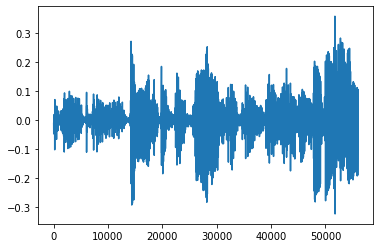

After augmentation


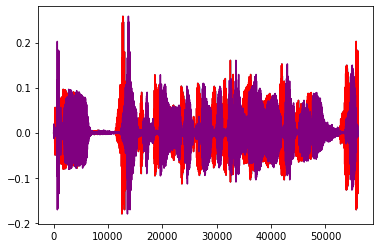

In [ ]:
print("Initial audio shape")
plt.figure()
plt.plot(audioTrs_train[3])
plt.show()

print("After augmentation")
plt.figure()
plt.plot(train_aug[3])
plt.plot(train_aug[4], 'r')
plt.plot(train_aug[5], 'purple')
plt.show()


In [ ]:
def preprocess_spec(x, sr):
  S_DB = []
  for i in range(x.shape[0]):
    S = librosa.feature.melspectrogram(x[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB = np.stack(S_DB, axis = 0)
  return S_DB

In [ ]:
SPEC = True
fuse = True

In [ ]:
if not download_audio_images and SPEC:
  sr = 16000

  #training 
  S_DB = []
  for i in range(train_aug.shape[0]):
    S = librosa.feature.melspectrogram(train_aug[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB = np.stack(S_DB, axis = 0)
    
  librosa.display.specshow(S_DB[2,:,:,0], sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

  # validation
  S_DB_val = []
  for i in range(audioTrs_val.shape[0]):
    S = librosa.feature.melspectrogram(audioTrs_val[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB_val.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB_val = np.stack(S_DB_val, axis = 0)

  plt.figure()
  librosa.display.specshow(S_DB_val[2,:,:,0], sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

  S_DB_test = []
  for i in range(audioTrs_test.shape[0]):
    S = librosa.feature.melspectrogram(audioTrs_test[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB_test.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB_test = np.stack(S_DB_test, axis = 0)


# Transformers Audio


https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/vit_small_ds.ipynb#scrollTo=J7w214BrTr_g


In [ ]:
# ViT
!pip install -qq -U tensorflow-addons

import tensorflow_addons as tfa
import math

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [ ]:
# DATA
BATCH_SIZE = 16                                                                      

# AUGMENTATION
IMAGE_SIZE = 72                                                                 
                             
# OPTIMIZER
LEARNING_RATE = 0.001                                                                
WEIGHT_DECAY = 0.0001                                                                 

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6     

NUM_HEADS=4

In [ ]:
# Scale spectrogram values to match cv image sizes
max_val = np.max([np.max(S_DB), np.max(S_DB_val), np.max(S_DB_test)])

S_DB = 255/max_val*S_DB
S_DB_val = 255/max_val*S_DB_val
S_DB_test = 255/max_val*S_DB_test

In [ ]:
fuse_id = []
for i in range(S_DB.shape[0]):
  fuse_id.append(i%3 == 0)
S_DB_fuse = S_DB[fuse_id]


In [ ]:
## Data adaptation for transformers

# Downsampling
import cv2
def downsample_image(dataset, chosen_input_size):
  # INTER_LINEAR or INTER_AREA
  return [cv2.resize(image, (chosen_input_size, chosen_input_size), interpolation=cv2.INTER_AREA) for image in dataset]

down_sample=True  # True to downsample dataset
down_sampled=False
fuse = True

if down_sample and not down_sampled:
  if not fuse:
    chosen_input_size=S_DB[0].shape[1]

    imgFrames_train=np.array(downsample_image(S_DB, chosen_input_size))
    imgFrames_val=np.array(downsample_image(S_DB_val, chosen_input_size))
    INPUT_SHAPE = (chosen_input_size, chosen_input_size, nb_channel)

  else:
    chosen_input_size=32
    INPUT_SHAPE_IMG = (chosen_input_size, chosen_input_size, nb_channel)
    imgFrames_train_img=np.array(downsample_image(imgFrames_train, chosen_input_size))
    imgFrames_val_img=np.array(downsample_image(imgFrames_val, chosen_input_size))
    imgFrames_test_img=np.array(downsample_image(imgFrames_test, chosen_input_size))

    chosen_input_size=S_DB[0].shape[1]
    INPUT_SHAPE_AUDIO = (chosen_input_size, chosen_input_size, nb_channel)

    imgFrames_train_audio=np.array(downsample_image(S_DB_fuse, chosen_input_size))
    imgFrames_val_audio=np.array(downsample_image(S_DB_val, chosen_input_size))
    imgFrames_test_audio=np.array(downsample_image(S_DB_test, chosen_input_size))

  down_sampled=True
elif  not down_sample and not down_sampled:
  if not fuse:
    INPUT_SHAPE = (input_size, input_size, nb_channel)
  else:
    chosen_input_size=S_DB[0].shape[1]
    INPUT_SHAPE_AUDIO = (chosen_input_size, chosen_input_size, nb_channel)
    chosen_input_size=32
    INPUT_SHAPE_IMG = (chosen_input_size, chosen_input_size, nb_channel)
else :
  print("Already downsampled")

print('Person :')
print(np.shape(person_val_GT)) 
print(np.shape(train_aug_GT)) 

print('Frame :')
print(np.shape(imgFrames_val)) 
print(np.shape(imgFrames_train)) 

NUM_CLASSES = nb_class


# Normalization and shuffle
norm=1 # already performed in data-augmentation

if fuse:
  x_train_img=imgFrames_train_img/norm
  r=random.sample(range(len(x_train_img)), len(x_train_img)) # shuffle data
  x_train_img=x_train_img[r]
  y_train_fuse=person_train_GT[r]

  x_train_audio=imgFrames_train_audio/norm
  x_train_audio=x_train_audio[r]
  #y_train_audio=train_aug_GT[r]

  x_test_audio = imgFrames_test_audio/norm
  x_test_img = imgFrames_test_img/norm
  r=random.sample(range(len(x_test_audio)), len(x_test_audio)) # shuffle data
  x_test_audio=x_test_audio[r]
  x_test_img=x_test_img[r]

  y_test_fuse=person_test_GT[r]


  x_val_img=imgFrames_val_img/norm
  r=random.sample(range(len(x_val_img)), len(x_val_img))
  x_val_img=x_val_img[r]
  y_val_fuse=person_val_GT[r]

  x_val_audio=imgFrames_val_audio/norm
  x_val_audio=x_val_audio[r]
  #y_val_audio=person_val_GT[r]


else:
  x_train=imgFrames_train/norm
  r=random.sample(range(len(x_train)), len(x_train)) # shuffle data
  x_train=x_train[r]
  y_train=train_aug_GT[r]

  x_val=imgFrames_val/norm
  r=random.sample(range(len(x_val)), len(x_val))
  x_val=x_val[r]
  y_val=person_val_GT[r]

Person :
(950,)
(8550,)
Frame :
(950, 224, 224, 3)
(2850, 224, 224, 3)


In [ ]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
if fuse:
  data_augmentation.layers[0].adapt(x_train_img)
else:
  data_augmentation.layers[0].adapt(x_train)



In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import time  
!wget https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg -O elephant.jpg
numTry = 1000
numParam = 25.6e6

with tf.device('/gpu:0'): # if using gpu for preprocessing /gpu:0
  model = ResNet50(weights='imagenet')  # num of params: 25.6 M
  img_path = 'elephant.jpg'
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  tic = time.perf_counter()
  for i in range(numTry):
    preds = model.predict(x)

  toc = time.perf_counter()
  totTime=toc-tic
  print("total time:",totTime)
  perRunTime = totTime/numTry
  paramSpeed=numParam/perRunTime
  print("number of parameters per second:",paramSpeed)
  tic = time.perf_counter()
  test_data_augmented = data_augmentation(x_train_img)
  toc = time.perf_counter()
  totTime=toc-tic
  perRunTime = totTime/(x_train_img.shape[0]) 
  print("Equivalent number of parameter for augmentation image ViT: {:}".format(perRunTime*paramSpeed))
  # time your preprocessing operation for one sample and multiply with this
  # value to calculate parameter count equivalency

--2022-05-30 13:18:28--  https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168370 (164K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 164.42K  --.-KB/s    in 0.06s   

2022-05-30 13:18:28 (2.75 MB/s) - ‘elephant.jpg’ saved [168370/168370]

total time: 50.46861964000004
number of parameters per second: 507245892.2516308
Equivalent number of parameter for augmentation image ViT: 3858.975464370349


In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

     |████████████████████████████████| 133 kB 6.5 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self, hp,
        image_size=IMAGE_SIZE,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = hp.Choice('patch_size',values=[4, 6, 12, 18, 24]) 
        self.half_patch = self.patch_size // 2
        self.flatten_patches = layers.Reshape(((self.image_size // self.patch_size) ** 2 , -1))
        self.projection = layers.Dense(units=hp.Choice('projection_dim',values=[32, 64, 128]))
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, hp,  images_size=IMAGE_SIZE, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = (images_size // hp.Choice('patch_size',values=[4, 6, 12, 18, 24])) ** 2
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=hp.Choice('projection_dim',values=[32, 64, 128]) 
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Tandhe trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        #print(attention_scores.shape,key.shape, query.shape)
       # print("x1", attention_scores.shape, attention_mask.shape)

        attention_scores = self._masked_softmax(attention_scores, attention_mask)

        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )

        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )

        return attention_output, attention_scores

In [ ]:

from keras.activations import softmax
class MultiHeadCrossAttention(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):

        query = tf.multiply(query, 1.0 / self.tau)

        key = tf.expand_dims(key, axis = 2)
        query = tf.expand_dims(query, axis = 2)
        value = tf.expand_dims(value, axis = 2)
        key_t = tf.transpose(key , perm=[0,1,3,2])

        attention_scores = tf.multiply(query,key_t)
        attention_scores2 = tf.divide(attention_scores,  22.62741)
        attention_scores3 = softmax(attention_scores2, axis=1)
        attention_scores4 = tf.einsum('nmij,nmkj->nmki', attention_scores3, value)
        attention_output = tf.concat([attention_scores4[:,0,:,:],attention_scores4[:,1,:,:],attention_scores4[:,2,:,:],attention_scores4[:,3,:,:]], axis=2)
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def ffn(x,x_dim, emb):
    x = layers.Dense(x_dim, activation=tf.nn.gelu)(x)
    x = layers.Dense(emb)(x)
    return x

In [ ]:

class create_vit_fused_classifier(kt.HyperModel):

  def __init__(self,input_shape_img = INPUT_SHAPE_IMG, input_shape_audio = INPUT_SHAPE_AUDIO):
    self.input_shape_img = input_shape_img
    self.input_shape_audio=input_shape_audio
    
      
  def build(self, hp, vanilla=False, image_size=IMAGE_SIZE):
    # Face stream
    inputs_img = layers.Input(shape=INPUT_SHAPE_IMG)

    # Build the diagonal attention mask
    diag_attn_mask = 1 - tf.eye((image_size // hp.Choice('patch_size',values=[4, 6, 12, 18, 24])) ** 2)
    diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

    # Augment data.
    augmented_img = data_augmentation(inputs_img)
    # Create patches.
    (tokens_img, _) = ShiftedPatchTokenization(hp, vanilla=vanilla)(augmented_img)
    # Encode patches.
    encoded_img_patches = PatchEncoder(hp)(tokens_img)
    # Create multiple layers of the Transformer block.
    for _ in range(hp.Choice('transformer_layers',values=[2, 4, 6, 8])):
        # Layer normalization 1.
        x1_img = layers.LayerNormalization(epsilon=1e-6)(encoded_img_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output_img = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=hp.Choice('projection_dim',values=[32, 64, 128]), dropout=0.1
            )(x1_img, x1_img, attention_mask=diag_attn_mask)
        else:
            attention_output_img = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=hp.Choice('projection_dim',values=[32, 64, 128]), dropout=0.1
            )(x1_img, x1_img)
        # Skip connection 1.
        x2_img = layers.Add()([attention_output_img, encoded_img_patches])
        # Layer normalization 2.
        x3_img = layers.LayerNormalization(epsilon=1e-6)(x2_img)
        # MLP.
        x3_img = mlp(x3_img, hidden_units=[hp.Choice('projection_dim',values=[32, 64, 128]) * 2, hp.Choice('projection_dim',values=[32, 64, 128]),] , dropout_rate=0.1)
        # Skip connection 2.
        encoded_img_patches = layers.Add()([x3_img, x2_img])
    # Create a [batch_size, projection_dim] tensor.
    representation_img = layers.LayerNormalization(epsilon=1e-6)(encoded_img_patches)
    representation_img = layers.Flatten()(representation_img)
    representation_img = layers.Dropout(0.5)(representation_img)
    representation_img = mlp(representation_img, hidden_units=[2*hp.Choice('mlp_head_units',values=[512, 256, 128]), hp.Choice('mlp_head_units',values=[512, 256, 128])], dropout_rate=0.5)


    img_stream_model = keras.Model(inputs=inputs_img, outputs=representation_img)


    # =========================================================================#

    # Audio stream
    inputs_audio = layers.Input(shape=INPUT_SHAPE_AUDIO)
    # Augment data.
    augmented_audio = data_augmentation(inputs_audio)
    # Create patches.
    (tokens_audio, _) = ShiftedPatchTokenization(hp, vanilla=vanilla)(augmented_audio)
    # Encode patches.
    encoded_audio_patches = PatchEncoder(hp)(tokens_audio)

    # Create multiple layers of the Transformer block.
    for _ in range(hp.Choice('transformer_layers',values=[2, 4, 6, 8])):
        # Layer normalization 1.
        x1_audio = layers.LayerNormalization(epsilon=1e-6)(encoded_audio_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output_audio = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=hp.Choice('projection_dim',values=[32, 64, 128]), dropout=0.1
            )(x1_audio, x1_audio, attention_mask=diag_attn_mask)
        else:
            attention_output_audio = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=hp.Choice('projection_dim',values=[32, 64, 128]), dropout=0.1
            )(x1_audio, x1_audio)
        # Skip connection 1.
        x2_audio = layers.Add()([attention_output_audio, encoded_audio_patches])
        # Layer normalization 2.
        x3_audio = layers.LayerNormalization(epsilon=1e-6)(x2_audio)
        # MLP.
        x3_audio = mlp(x3_audio, hidden_units=[hp.Choice('projection_dim',values=[32, 64, 128]) * 2, hp.Choice('projection_dim',values=[32, 64, 128]),] , dropout_rate=0.1)
        # Skip connection 2.
        encoded_audio_patches = layers.Add()([x3_audio, x2_audio])
      # Create a [batch_size, projection_dim] tensor.
    representation_audio = layers.LayerNormalization(epsilon=1e-6)(encoded_audio_patches)
    representation_audio = layers.Flatten()(representation_audio)
    representation_audio = layers.Dropout(0.5)(representation_audio)
    representation_audio = mlp(representation_audio, hidden_units=[2*hp.Choice('mlp_head_units',values=[512, 256, 128]), hp.Choice('mlp_head_units',values=[512, 256, 128])], dropout_rate=0.5)
    # End encoder stream 

    audio_stream_model = keras.Model(inputs=inputs_audio, outputs=representation_audio)

    # ====================================================================
    q2 = audio_stream_model.output
    k1 = img_stream_model.output
    v1 = img_stream_model.output
    #print("qk",q2.shape, k1.shape)

    q1 = img_stream_model.output
    k2 = audio_stream_model.output
    v2 = audio_stream_model.output

    # num_heads=hp.Choice('num_heads',values=[2,3,4,5,6,7,8])
  # hp.Choice('mlp_head_units',values=[512, 256, 128])

    attention_output_1 = MultiHeadCrossAttention(num_heads=NUM_HEADS, key_dim=hp.Choice('mlp_head_units',values=[512, 256, 128]), dropout=0.1)(query= q2, key= k1, value= v1)#, attention_mask=diag_attn_mask1)
    attention_output_2 = MultiHeadCrossAttention(num_heads=NUM_HEADS, key_dim=hp.Choice('mlp_head_units',values=[512, 256, 128]), dropout=0.1)(query= q1, key= k2, value= v2)#, attention_mask=diag_attn_mask1)
    #print("after MHCA",attention_output_1.shape,attention_output_2.shape )
    attention_output_1 = layers.Dense(hp.Choice('mlp_head_units',values=[512, 256, 128]), activation=None)(attention_output_1)
    attention_output_2 = layers.Dense(hp.Choice('mlp_head_units',values=[512, 256, 128]), activation=None)(attention_output_2)

    MHD_1 = layers.Add()([tf.expand_dims(img_stream_model.output, axis = 1), tf.expand_dims(attention_output_1, axis = 1)])
    MHD_2 = layers.Add()([tf.expand_dims(audio_stream_model.output, axis = 1), tf.expand_dims(attention_output_2, axis = 1)])

    output_MH = layers.Concatenate()([MHD_1, MHD_2])
    # last linear output  
    # Add MLP.
    representation = layers.LayerNormalization(epsilon=1e-6)(output_MH)
    representation = layers.Flatten()(representation)
    #print(representation.shape)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    #features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    features = ffn(representation, x_dim=hp.Choice('mlp_head_units',values=[512, 256, 128]), emb=hp.Choice('projection_dim',values=[32, 64, 128]))
    
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    model = keras.Model(inputs=[img_stream_model.input, audio_stream_model.input], outputs=logits)
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    return model

  # def fit(self, hp, model, batch_size=BATCH_SIZE, *args, **kwargs):

  #     return model.fit(*args,batch_size=batch_size,**kwargs,)

In [ ]:
tuner_random_img = RandomSearch(create_vit_fused_classifier(input_shape_img = INPUT_SHAPE_IMG, input_shape_audio = INPUT_SHAPE_AUDIO), objective='val_accuracy', max_trials=5, executions_per_trial=1, project_name='Hyperparameters_random', overwrite=True)

In [ ]:
tuner_random_img.search_space_summary()

Search space summary
Default search space size: 4
patch_size (Choice)
{'default': 4, 'conditions': [], 'values': [4, 6, 12, 18, 24], 'ordered': True}
projection_dim (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
transformer_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 6, 8], 'ordered': True}
mlp_head_units (Choice)
{'default': 512, 'conditions': [], 'values': [512, 256, 128], 'ordered': True}


In [ ]:
tuner_random_img.search([x_train_img, x_train_audio], y_train_fuse, epochs=20,  validation_data=([x_val_img, x_val_audio], y_val_fuse))

Trial 5 Complete [00h 03m 00s]
val_accuracy: 0.3663157820701599

Best val_accuracy So Far: 0.5673684477806091
Total elapsed time: 00h 29m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_random_img.results_summary()

Results summary
Results in ./Hyperparameters_random
Showing 10 best trials
Trial summary
Hyperparameters:
patch_size: 6
projection_dim: 64
transformer_layers: 4
mlp_head_units: 512
Score: 0.5673684477806091
Trial summary
Hyperparameters:
patch_size: 4
projection_dim: 64
transformer_layers: 4
mlp_head_units: 128
Score: 0.44631579518318176
Trial summary
Hyperparameters:
patch_size: 4
projection_dim: 32
transformer_layers: 6
mlp_head_units: 128
Score: 0.4442105293273926
Trial summary
Hyperparameters:
patch_size: 24
projection_dim: 32
transformer_layers: 8
mlp_head_units: 512
Score: 0.37684211134910583
Trial summary
Hyperparameters:
patch_size: 18
projection_dim: 32
transformer_layers: 4
mlp_head_units: 256
Score: 0.3663157820701599


In [ ]:
def custom_metric(model, y_pred, y_true):
  acc = tf.metrics.accuracy(y_true, y_pred)[1]
  param = model.counts_param()
  ratio=param/10000000

In [ ]:
def plot_loss_and_accuracy(history_sl):
  # model loss
  loss='categorical_crossentropy'
  metrics=['accuracy']

  plt.plot(history_sl.history['loss'])
  plt.plot(history_sl.history['val_loss'])
  plt.title('Model loss : ' + loss)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='best')
  plt.show()
  plt.close()

  # model accuracy metric
  plt.plot(np.array(history_sl.history[metrics[0]]))
  plt.plot(np.array(history_sl.history['val_' + metrics[0]]))
  plt.title('Model accuracy metric : ' + metrics[0])
  plt.ylabel('Accuracy metric')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='best')
  plt.show()
  plt.close()

# Test found parameters

In [ ]:
# DATA
BUFFER_SIZE = 64 #512
BATCH_SIZE = 32 #256

# AUGMENTATION
IMAGE_SIZE = 72 #72
PATCH_SIZE = 6 #6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 100

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6#1e-6
TRANSFORMER_LAYERS = 4 #8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]

MLP_LS = [1024,512]#[2048, 1024]

MLP_HEAD_UNITS =[1024,512]# [2048, 1024]


In [ ]:
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

diag_attn_mask1 = 1 - tf.eye(MLP_LS[-1])
diag_attn_mask1 = tf.cast([diag_attn_mask1], dtype=tf.int8)

diag_attn_mask2 = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask2 = tf.cast([diag_attn_mask2], dtype=tf.int8)

In [ ]:
class ShiftedPatchTokenization_test(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder_test(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
def create_vit_fused_classifier_test(vanilla=False):
  # Face stream
  inputs_img = layers.Input(shape=INPUT_SHAPE_IMG)
  inputs_audio = layers.Input(shape=INPUT_SHAPE_AUDIO)

  # Augment data.
  augmented_img = data_augmentation(inputs_img)
  # Create patches.
  (tokens_img, _) = ShiftedPatchTokenization_test(vanilla=vanilla)(augmented_img)
  # Encode patches.
  encoded_img_patches = PatchEncoder_test()(tokens_img)

  # Create multiple layers of the Transformer block.
  for _ in range(TRANSFORMER_LAYERS):
      # Layer normalization 1.
      x1_img = layers.LayerNormalization(epsilon=1e-6)(encoded_img_patches)
      # Create a multi-head attention layer.
      if not vanilla:
          attention_output_img = MultiHeadAttentionLSA(
              num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
          )(x1_img, x1_img, attention_mask=diag_attn_mask)
      else:
          attention_output_img = layers.MultiHeadAttention(
              num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
          )(x1_img, x1_img)
      # Skip connection 1.
      x2_img = layers.Add()([attention_output_img, encoded_img_patches])
      # Layer normalization 2.
      x3_img = layers.LayerNormalization(epsilon=1e-6)(x2_img)
      # MLP.
      x3_img = mlp(x3_img, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
      # Skip connection 2.
      encoded_img_patches = layers.Add()([x3_img, x2_img])
      # Create a [batch_size, projection_dim] tensor.
  representation_img = layers.LayerNormalization(epsilon=1e-6)(encoded_img_patches)
  representation_img = layers.Flatten()(representation_img)
  representation_img = layers.Dropout(0.5)(representation_img)
  representation_img = mlp(representation_img, hidden_units=MLP_LS, dropout_rate=0.5)

  img_stream_model = keras.Model(inputs=inputs_img, outputs=representation_img)

  # =========================================================================#

  # Audio stream
  # Augment data.
  augmented_audio = data_augmentation(inputs_audio)
  # Create patches.
  (tokens_audio, _) = ShiftedPatchTokenization_test(vanilla=vanilla)(augmented_audio)
  # Encode patches.
  encoded_audio_patches = PatchEncoder_test()(tokens_audio)

  # Create multiple layers of the Transformer block.
  for _ in range(TRANSFORMER_LAYERS):
      # Layer normalization 1.
      x1_audio = layers.LayerNormalization(epsilon=1e-6)(encoded_audio_patches)
      # Create a multi-head attention layer.
      if not vanilla:
          attention_output_audio = MultiHeadAttentionLSA(
              num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
          )(x1_audio, x1_audio, attention_mask=diag_attn_mask)
      else:
          attention_output_audio = layers.MultiHeadAttention(
              num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
          )(x1_audio, x1_audio)
      # Skip connection 1.
      x2_audio = layers.Add()([attention_output_audio, encoded_audio_patches])
      # Layer normalization 2.
      x3_audio = layers.LayerNormalization(epsilon=1e-6)(x2_audio)
      # MLP.
      x3_audio = mlp(x3_audio, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
      # Skip connection 2.
      encoded_audio_patches = layers.Add()([x3_audio, x2_audio])
    # Create a [batch_size, projection_dim] tensor.
  representation_audio = layers.LayerNormalization(epsilon=1e-6)(encoded_audio_patches)
  representation_audio = layers.Flatten()(representation_audio)
  representation_audio = layers.Dropout(0.5)(representation_audio)
  representation_audio = mlp(representation_audio, hidden_units=MLP_LS, dropout_rate=0.1)
  # End encoder stream 

  audio_stream_model = keras.Model(inputs=inputs_audio, outputs=representation_audio)

  # ====================================================================
  q2 = audio_stream_model.output
  k1 = img_stream_model.output
  v1 = img_stream_model.output
  #print("qk",q2.shape, k1.shape)

  q1 = img_stream_model.output
  k2 = audio_stream_model.output
  v2 = audio_stream_model.output

  attention_output_1 = MultiHeadCrossAttention(num_heads=NUM_HEADS, key_dim=MLP_LS[-1], dropout=0.1)(query= q2, key= k1, value= v1)#, attention_mask=diag_attn_mask1)
  attention_output_2 = MultiHeadCrossAttention(num_heads=NUM_HEADS, key_dim=MLP_LS[-1], dropout=0.1)(query= q1, key= k2, value= v2)#, attention_mask=diag_attn_mask1)

  # linear layer 
  attention_output_1 = layers.Dense(MLP_LS[-1], activation=None)(attention_output_1)
  attention_output_2 = layers.Dense(MLP_LS[-1], activation=None)(attention_output_2)

  
  MHD_1 = layers.Add()([tf.expand_dims(img_stream_model.output, axis = 1), tf.expand_dims(attention_output_1, axis = 1)])
  MHD_2 = layers.Add()([tf.expand_dims(audio_stream_model.output, axis = 1), tf.expand_dims(attention_output_2, axis = 1)])

  output_MH = layers.Concatenate()([MHD_1, MHD_2])

  # last output  
  representation = layers.LayerNormalization(epsilon=1e-6)(output_MH)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)
  # Add FFN
  features = ffn(representation, 512, 64)
  
  # Classify outputs.
  logits = layers.Dense(NUM_CLASSES)(features)

  model = keras.Model(inputs=[img_stream_model.input, audio_stream_model.input], outputs=logits)
  return model

In [ ]:
LEARNING_RATE = 0.001
def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop =  100.0
    return LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))
y_val_fuse_oh = tf.keras.utils.to_categorical(y_val_fuse, nb_class)  # create one-hot encoded class
y_train_fuse_oh = tf.keras.utils.to_categorical(y_train_fuse, nb_class)  # create one-hot encoded class

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_fuse_experiment(model, train=True):
    total_steps = int((len(x_train_img) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )


    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    model.summary()
    if train:
      history = model.fit(
          x=[x_train_img, x_train_audio],
          y=y_train_fuse,
          batch_size=BATCH_SIZE,
          epochs=150,
          validation_data=([x_val_img, x_val_audio],y_val_fuse),
          callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)]
      )
    else:
      history = []

    return history

In [ ]:
# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_fuse = create_vit_fused_classifier_test(vanilla=False)
history_fuse = run_fuse_experiment(vit_fuse)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                            

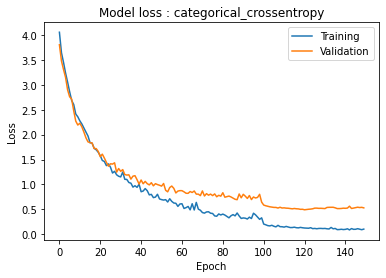

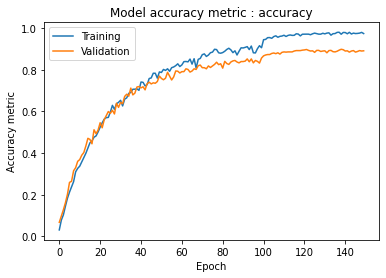

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(history_fuse.history['loss'])
plt.plot(history_fuse.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history_fuse.history[metrics[0]]))
plt.plot(np.array(history_fuse.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()



In [ ]:
test_model_ViT = True

if test_model_ViT:  
  _, accuracy, top_5_accuracy = vit_fuse.evaluate([x_test_img,x_test_audio], y_test_fuse, batch_size=BATCH_SIZE)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

30/30 [==============================] - 3s 101ms/step - loss: 0.5590 - accuracy: 0.8916 - top-5-accuracy: 0.9632
Test accuracy: 89.16%
Test top 5 accuracy: 96.32%
